# Virulent Prediction

In [1]:
'''
!rm -r iFeature
!git clone https://github.com/Superzchen/iFeature
!python iFeature/iFeature.py --file ./input.fasta --type AAC --out aac.out # amino acids composition
!python iFeature/iFeature.py --file ./input.fasta --type DPC --out dpc.out # dipeptide composition
!python iFeature/iFeature.py --file ./input.fasta --type CTDC --out ctdc.out # composition
!python iFeature/iFeature.py --file ./input.fasta --type CTDT --out ctdt.out # transition
!python iFeature/iFeature.py --file ./input.fasta --type CTDD --out ctdd.out # distribution
'''

'\n!rm -r iFeature\n!git clone https://github.com/Superzchen/iFeature\n!python iFeature/iFeature.py --file ./input.fasta --type AAC --out aac.out # amino acids composition\n!python iFeature/iFeature.py --file ./input.fasta --type DPC --out dpc.out # dipeptide composition\n!python iFeature/iFeature.py --file ./input.fasta --type CTDC --out ctdc.out # composition\n!python iFeature/iFeature.py --file ./input.fasta --type CTDT --out ctdt.out # transition\n!python iFeature/iFeature.py --file ./input.fasta --type CTDD --out ctdd.out # distribution\n'

In [2]:
!rm -r virulent_factor_classification
!git clone https://github.com/nicolagulmini/virulent_factor_classification
from virulent_factor_classification.model import *

Cloning into 'virulent_factor_classification'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 79 (delta 23), reused 36 (delta 10), pack-reused 0
Unpacking objects: 100% (79/79), done.
Checking out files: 100% (16/16), done.


In [3]:
!pip install Bio
from Bio import SeqIO
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'positive_virulent.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'negative_virulent.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [5]:
positive_datasets = from_files_to_vectors('./virulent_factor_classification/training/positive/')
negative_datasets = from_files_to_vectors('./virulent_factor_classification/training/negative/', positive=False)

In [6]:
def from_vectors_to_train_and_test_with_labels(positive_datasets, negative_datasets):
    if not (len(positive_datasets) == 5 and len(negative_datasets) == 5):
        print("Error in datasets!")
        return

    x_train_pos_len = int(len(positive_datasets[0])/2)
    x_train_neg_len = int(len(negative_datasets[0])/2)
    x_train_len = x_train_pos_len + x_train_neg_len

    x_val_pos_len = int(len(positive_datasets[0])/4)
    x_val_neg_len = int(len(negative_datasets[0])/4)
    x_val_len = x_val_pos_len + x_val_neg_len

    x_test_pos_len = len(positive_datasets[0])-x_train_pos_len-x_val_pos_len
    x_test_neg_len = len(negative_datasets[0])-x_train_neg_len-x_val_neg_len
    x_test_len = x_test_pos_len + x_test_neg_len
    
    positive_labels = [1. for _ in range(len(positive_datasets[0]))]
    negative_labels = [0. for _ in range(len(negative_datasets[0]))]

    x_train, y_train, x_val, y_val, x_test, y_test = [[] for _ in range(6)]
    x_train = [positive_datasets[i][:x_train_pos_len].tolist()+negative_datasets[i][:x_train_neg_len].tolist() for i in range(5)]
    y_train = [1. for _ in range(x_train_pos_len)]+[0. for _ in range(x_train_neg_len)]

    x_val = [positive_datasets[i][x_train_pos_len:x_train_pos_len+x_val_pos_len].tolist()+negative_datasets[i][x_train_neg_len:x_train_neg_len+x_val_neg_len].tolist() for i in range(5)]
    y_val = [1. for _ in range(x_val_pos_len)]+[0. for _ in range(x_val_neg_len)]

    x_test = [positive_datasets[i][x_train_pos_len+x_val_pos_len:x_train_pos_len+x_val_pos_len+x_test_pos_len].tolist()+negative_datasets[i][x_train_neg_len+x_val_neg_len:x_train_neg_len+x_val_neg_len+x_test_neg_len].tolist() for i in range(5)]
    y_test = [1. for _ in range(x_test_pos_len)]+[0. for _ in range(x_test_neg_len)]

    for i in range(5):
        for el in x_train[i]:
            el = np.array(el)
        x_train[i] = np.array(x_train[i])

    for i in range(5):
        for el in x_val[i]:
            el = np.array(el)
        x_val[i] = np.array(x_val[i])

    for i in range(5):
        for el in x_test[i]:
            el = np.array(el)
        x_test[i] = np.array(x_test[i])

    return x_train, np.array(y_train), x_val, np.array(y_val), x_test, np.array(y_test)

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = from_vectors_to_train_and_test_with_labels(positive_datasets, negative_datasets)

## Training

In [14]:
model = virulent_factor_classification_model()
epochs = 20

In [15]:
history = model.get_model().fit(
    x=x_train,
    y=y_train,
    epochs=epochs, 
    verbose=0, 
    validation_data=(x_val, y_val),
    shuffle=True    
    )

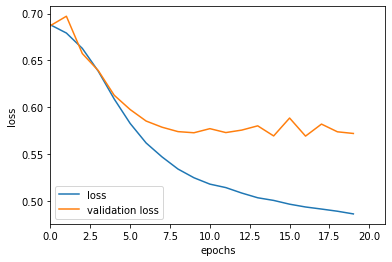

In [16]:
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='validation loss')

plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0, epochs+1)
plt.show()

In [17]:
plt.savefig('plot.png')

<Figure size 432x288 with 0 Axes>

In [18]:
print("Test accuracy: " + str(model.get_model().evaluate(
    x=x_test,
    y=y_test   
    )[1]))

174/174 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.7603
Test accuracy: 0.7603097558021545


In [19]:
model.get_model().save('trained_model.h5')